# 自己組織化マップと視覚野の構造
視覚野にはコラム構造が存在する．こうした構造は神経活動依存的な発生 （activity dependent development）により獲得される．本節では視覚野のコラム構造を生み出す数理モデルの中で，**自己組織化マップ (self-organizing map)** {cite:p}`Kohonen1982-mn`, {cite:p}`Kohonen2013-yt`を取り上げる．

自己組織化マップを視覚野の構造に適応したのは{cite:p}`Obermayer1990-gq` {cite:p}`N_V_Swindale1998-ri`などの研究である．視覚野マップの数理モデルとして自己組織化マップは受容野を考慮しないなどの簡略化がなされているが，単純な手法にして視覚野の構造に関する良い予測を与える．他の数理モデルとしては自己組織化マップと発想が類似している **Elastic net**  {cite:p}`Durbin1987-bp` {cite:p}`Durbin1990-xx` {cite:p}`Carreira-Perpinan2005-gy`　(ここでのElastic netは正則化手法としてのElastic net regularizationとは異なる)や受容野を明示的に設定した {cite:p}`Tanaka2004-vz`， {cite:p}`Ringach2007-oe`などのモデルがある．総説としては{cite:p}`Das2005-mq`，{cite:p}`Goodhill2007-va` ，数理モデル同士の関係については{cite:p}`2002-nm`が詳しい．

自己組織化マップでは「抹消から中枢への伝達過程で損失される情報量」，および「近い性質を持ったニューロン同士が結合するような配線長」の両者を最小化するような学習が行われる．包括性 (coverage) と連続性 (continuity) のトレードオフとも呼ばれる {cite:p}`Carreira-Perpinan2005-gy`　（Elastic netは両者を明示的に計算し，線形結合で表されるエネルギー関数を最小化する．Elastic netは本書では取り扱わないが，MATLAB実装が公開されている
[https://faculty.ucmerced.edu/mcarreira-perpinan/research/EN.html]）． 連続性と関連する事項として，近い性質を持つ細胞が脳内で近傍に存在する現象があり，これを**トポグラフィックマッピング (topographic mapping)** と呼ぶ．トポグラフィックマッピングの数理モデルの初期の研究としては{cite:p}`Von_der_Malsburg1973-bz` {cite:p}`Willshaw1976-zo` {cite:p}`Takeuchi1979-mi`などがある．

## 単純なデータセット

入力を $\mathbf{v}\in \mathbb{R}^{N\times D}$, SOMモデルにおけるニューロンの活動ベクトルあるいは参照ベクトルを$\mathbf{w}\in \mathbb{R}^{M\times D}$とする　{cite:p}`Kohonen2013-yt`．

n番目の入力 $\mathbf{v}(t)=\mathbf{v}_n\in \mathbb{R}^{D} (n=1, \ldots, N)$に対して，m番目のニューロン$（m=1, \ldots, M）$の活動ベクトル$\mathbf{w}_m(t)\in \mathbb{R}^{D}$を以下のように更新する (重みではなく活動自体を更新するということに注意)．

まず，$\mathbf{v}(t)$と活動ベクトル$\mathbf{w}_m(t)$が最も近いニューロンを見つける．距離はユークリッド距離を用いるのが標準である．

$$
c = \underset{m}{\operatorname{argmin}}\{||\mathbf{v}(t)-\mathbf{w}_m(t)||\}
$$

この，$c$番目のニューロンを勝者ユニット(best matching unit; BMU)と呼ぶ．

$$
\mathbf{w}_m(t+1)=\mathbf{w}_m(t)+h_{cm}(t)[\mathbf{v}(t)-\mathbf{w}_m(t)]
$$

ここで$h_{cm}(t)$は近傍関数 (neighborhood function) と呼ばれ，$c$番目と$m$番目のニューロンの距離が近いほど大きな値を取る．ガウス関数を用いるのが一般的である．

$$
h_{cm}(t)=\alpha(t)\exp\left(-\frac{||\mathbf{x}_c-\mathbf{x}_m||^2}{2\sigma^2(t)}\right)
$$

ここで$\mathbf{x}$はニューロンの位置を表すベクトルである．また，$\alpha(t), \sigma(t)$は単調に減少するように設定する．

ここまではオンライン学習の手法であった．一方でデータセット全体について更新を行う場合は以下のような式を用いる．

$$
\mathbf{w}^*_m = \frac{\sum_t h_{cm}(t) \mathbf{v}(t)}{\sum_t h_{cm}(t)}
$$

今回は省略する．

In [1]:
using Random, PyPlot, ProgressMeter

In [2]:
# inputs 
N = 400 # num of inputs
dims = 2  # dims of inputs 
Random.seed!(1234);
σv, σw = 0.2, 0.05
v = [σv*randn(Int(N/2), dims);  1.0 .+ σv*randn(Int(N/2), dims)]
map_width = 10
w = σw*randn(map_width, map_width, dims) .+ 0.5;

In [3]:
function plot_som(v, w)
    scatter(v[:, 1], v[:, 2], s=10)
    plot(w[:, :, 1], w[:, :, 2], "k", alpha=0.8); plot(w[:, :, 1]', w[:, :, 2]', "k", alpha=0.8)
    scatter(w[:, :, 1], w[:, :, 2], s=10) # w[i, j, 1]とw[i, j, 2]の点をプロット
end;

近傍関数 (neighborhood function)のための二次元ガウス関数を実装する．Winnerニューロンからの距離に応じて値が減弱する関数である．ここでは一つの入力に対して全てのニューロンの活動ベクトルを更新するということはせず，winner neuronの近傍のニューロンのみ更新を行う．つまり，更新においてはglobalではなくlocalな処理のみを行うということである （Winner neuronの決定にはWTAによるglobalな評価が必要ではあるが）．

In [4]:
# Gaussian mask for inputs
function gaussian_mask(sizex=9, sizey=9; σ=5)
    x, y = 0:sizex-1, 0:sizey-1
    X, Y = ones(sizey) * x', y * ones(sizex)' 
    x0, y0 = (sizex-1) / 2, (sizey-1) / 2
    mask = exp.(-((X .- x0) .^2 + (Y .- y0) .^2) / (2.0(σ^2)))
    return mask ./ sum(mask)
end;

自己組織化マップのメインとなる関数を書く．

In [5]:
function SOM!(v, w; α0=1.0, σ0=6, T=500)
    # α0: update rate, σ0 : width, T : training steps
    map_width = size(w)[1]
    N = size(v)[1]
    w_history = [copy(w)] # history of w
    @showprogress for t in 1:T
        α = α0 * (1 - t/T); # update rate
        σ = (σ0 - 1) * (1 - t/T) + 1; # decay from large to small
        wm = ceil(Int, σ)
        h = gaussian_mask(2wm+1, 2wm+1, σ=σ);
        # loop for the N inputs
        for i in 1:N
            dist = sum([(v[i, j] .- w[:, :, j]).^2 for j in 1:dims]) # distance between input and neurons
            win_idx = argmin(dist) # winner index
            idx = [max(1,win_idx[j] - wm):min(map_width, win_idx[j] + wm) for j in 1:2] # neighbor indices
            # update the winner & neighbor neuron
            η = α * h[1:length(idx[1]), 1:length(idx[2])]
            for j in 1:dims
                w[idx..., j] += η .* (v[i, j] .- w[idx..., j])
            end
        end
        append!(w_history, [copy(w)]) # save w
    end
    return w_history
end;

In [6]:
w_history = SOM!(v, w, α0=1.0, σ0=6, T=100);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


青点が$\mathbf{v}$，オレンジの点が$\mathbf{w}$である．黒線はニューロン間の位置関係を表す．下段のヒートマップは$\mathbf{w}$の一番目の次元を表す．学習が進むとともに近傍のニューロンが近い活動ベクトルを持つことがわかる．

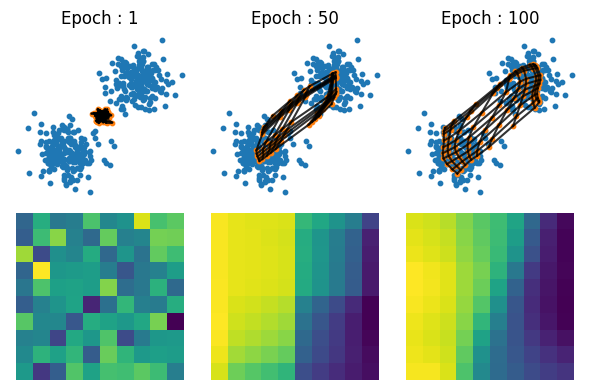

In [7]:
figure(figsize=(6, 4)) 
idx = [1, 50, 100]
for i in 1:length(idx)
    wh = w_history[idx[i]]
    subplot(2,length(idx),i)
    title("Epoch : "*string(idx[i]))
    plot_som(v, wh); axis("off")
    subplot(2,length(idx),i+length(idx))
    imshow(wh[:, :, 1]); axis("off")
end
tight_layout()

## 視覚野マップ

集合の直積を配列として返す関数 `product`と極座標を直交座標に変換する関数 `pol2cart`を用意する．

In [8]:
product(sets...) = hcat([collect(x) for x in Iterators.product(sets...)]...)' # Array of Cartesian product of sets 
pol2cart(θ, r) = r*[cos(θ), sin(θ)];

刺激と初期の活動ベクトルは{cite:p}`Carreira-Perpinan2005-gy`　を参考に作成．

In [9]:
# generate stimulus
Random.seed!(1234);
Nx, Ny, NOD, NOR = 10, 10, 2, 12
dims = 5  # dims of inputs 
l, r = 0.14, 0.2

rx, ry = range(0, 1, length=Nx), range(0, 1, length=Ny)
rOD = range(-l, l, length=NOD)
rORθ = range(-π/2, π/2, length=NOR+1)[1:end-1]

# stimuli
v = product(rx, ry, rOD, rORθ, r)
rORxy = hcat(pol2cart.(2v[:, 4], v[:, 5])...)
v[:, 4], v[:, 5] = rORxy[1, :], rORxy[2, :];
v += (rand(size(v)...) .- 1) * 1e-5;

# initial neurons
map_width = 64
M = map_width^2
w = product(range(0, 1, length=map_width), range(0, 1, length=map_width))
w += (rand(size(w)...) .- 1) * 0.05;
w = [w 2l*(rand(M) .- 0.5) hcat(pol2cart.(4π*(rand(M) .- 0.5), r*rand(M))...)']
w = reshape(w, (map_width, map_width, dims));

In [10]:
SOM!(v, w, α0=1.0, σ0=5, T=50);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:23


描画用関数を実装する． `w_history`を用いてアニメーションを作成すると発達の過程が可視化されるが，これは読者への課題とする．

In [11]:
function plot_visual_maps(v, w)
    figure(figsize=(9, 8))
    subplot(2,2,1, adjustable="box", aspect=1); title("Retinotopic map")
    plot_som(v, w)

    ax1 = subplot(2,2,2, adjustable="box", aspect=1); title("Ocular dominance (OD) map")
    imshow(w[:, :, 3], cmap="gray", origin="lower") 
    
    ins1 = ax1.inset_axes([1.05,0,0.05,1])
    colorbar(cax=ins1, aspect=40, pad=0.08, shrink=0.6)
    ins1.text(0, -0.15, "Left", ha="center", va="center")
    ins1.text(0, 0.15, "Right", ha="center", va="center")
    
    subplot(2,2,3, adjustable="box", aspect=1); title("Contours of OD and OR")
    ORmap = atan.(w[:, :, 5], w[:, :, 4]); # get angle of polar 
    sizex, sizey = map_width, map_width
    x, y = 0:sizex-1, 0:sizey-1
    X, Y = ones(sizey) * x', y * ones(sizex)';
    contour(X, Y, ORmap, cmap="hsv")
    contour(X, Y, w[:, :, 3], colors="k", levels=1)

    ax2 = subplot(2,2,4, adjustable="box", aspect=1); title("Orientation (OR) angle map")
    imshow(ORmap, cmap="hsv", origin="lower")
    
    cm = get_cmap(:hsv)
    lines, colors = [], []
    for i in 1:9
        θ = (i-1)/8*π
        c, s = cos(θ), sin(θ)
        push!(lines, [(-c/2, 15-1.5i -s/2), (c/2, 15-1.5i + s/2)])
        push!(colors, cm(1/8*(i-1)))
    end
    
    ins2 = ax2.inset_axes([1,0,0.2,1])
    ins2.add_collection(matplotlib.collections.LineCollection(lines, linewidths=3,color=colors))
    ins2.set_aspect("equal")
    ins2.axis("off")
    ins2.set_xlim(-1, 1); ins2.set_ylim(0, 15)
    
    tight_layout()
end;

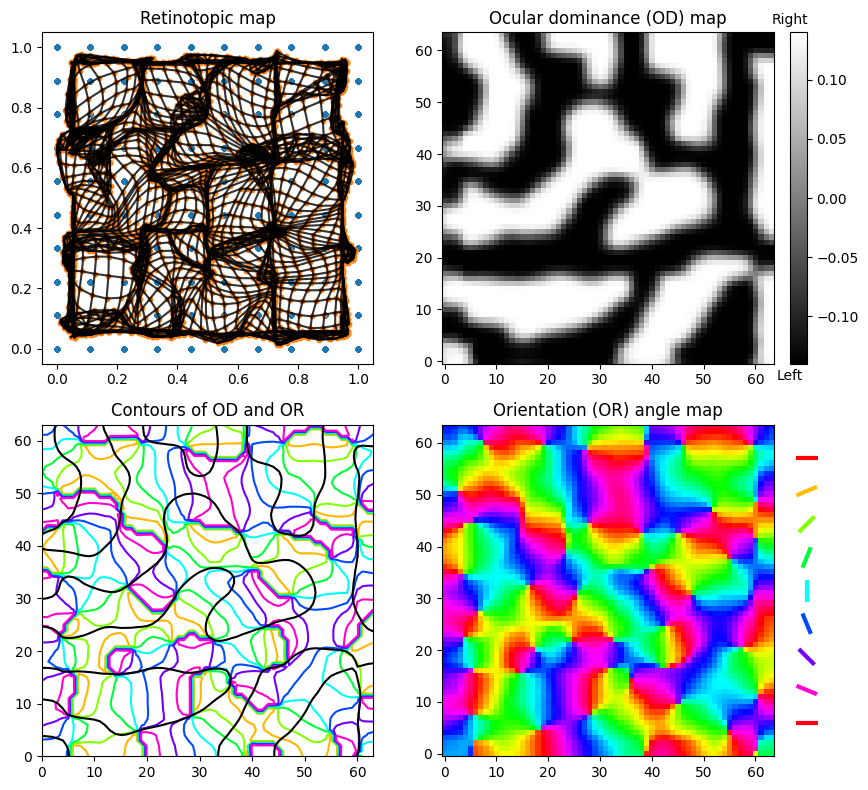

In [12]:
plot_visual_maps(v, w)

## 参考文献
```{bibliography}
:filter: docname in docnames
```